# Are horoscopes inherently related?

Much of the western world's superstition has fallen on ancient wisdom of astral bodies, called zodiac signs. Almost every day, foresight of a person is relayed through mass media via newspapers, or more commonly in today's era, websites. The following of astrology and horoscopes, while highly debated for its truth, have its followers. Predictions that ring true to those who find its parallel in their daily life continue to refer to the stars for answers.

But is there any structure to this prescience? Are the stars really sending a message beyond random electromagnetic radiation? Let's have a look.

---

We are going to use data that is scraped from two websites: Astrology.com and Horoscopes.com as they show up first in Google search. Both sites feature readings for yesterday, today and tomorrow. We scraped the horoscopes for the date of June 16th.

**Note:** The scraper was developed using `scrapy` and can be found under the `horoscope/` folder.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from nltk import word_tokenize
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

Let's load up the scraped data. 

In [2]:
with open('astrology.json', 'r') as f:
    data_astrology = json.load(f)

with open('horoscope_com.json', 'r') as f:
    data_horoscope = json.load(f)

data = data_astrology + data_horoscope

To convert the horoscopes into useable vectors, we will use the [GloVe vector](https://nlp.stanford.edu/projects/glove/) as it is easily readable on a laptop without a memory overload (and it's a decent vector model).

To interface with GloVe, `gensim` provides a `KeyedVector` model which maps words into it's counterpart vector and is quite efficient at handling larger vectors like Google News.

**Note:** The code might take a while to load up the entire vector model, so grap a cuppa while you run the next line.

In [3]:
glove = KeyedVectors.load_word2vec_format('/home/syafiq/Data/gs.glove.6B.100d.txt', binary=False)

Let's also load the data into a `pandas.DataFrame` so we can see it a little better.

In [4]:
signs_map = {
    'aries': '♈',
    'taurus': '♉',
    'gemini': '♊',
    'cancer': '♋',
    'leo': '♌',
    'virgo': '♍',
    'libra': '♎',
    'scorpio': '♏',
    'sagittarius': '♐',
    'capricorn': '♑',
    'aquarius': '♒',
    'pisces': '♓',
}

horoscopes = np.array([d['horoscope'] for d in data]).reshape(-1, 1)
signs = np.array([d['sign'] for d in data]).reshape(-1, 1)
days = np.array([d['day'] for d in data]).reshape(-1, 1)
sources_list = (
    (['Astrology.com'] * len(data_astrology)) +
    (['Horoscope.com'] * len(data_horoscope))
)
sources = np.array(sources_list).reshape(-1, 1)

df = pd.DataFrame(np.hstack([horoscopes, signs, days, sources]),
                  columns=['Horoscope', 'Sign', 'Day', 'Source'])
df.sample(8)

,Horoscope,Sign,Day,Source
61,Today you might consider entering into a busin...,cancer,tomorrow,Horoscope.com
13,It's indisputable that you have a way with wor...,virgo,today,Astrology.com
62,The value of any investment you may have made ...,leo,tomorrow,Horoscope.com
57,"Matters involving creativity, romance, and chi...",taurus,tomorrow,Horoscope.com
21,"The past week has been busy, varied and full o...",taurus,tomorrow,Astrology.com
54,An engagement with a current or potential roma...,scorpio,today,Horoscope.com
64,"A lot of serious matters are on your mind, per...",libra,tomorrow,Horoscope.com
34,All kinds of really interesting people have be...,aquarius,tomorrow,Astrology.com


---

## Raw findings

We will first look at the structure of the horoscopes before using the GloVe vectors, just so we can confirm findings. One way to make a vectorized version of the horoscopes is to weigh important words higher and not-so-important words (like I, you, a, an, then) lower. An easy algorithm to do so is [TF-IDF](http://www.tfidf.com/).

Then, we can use PCA to project the "document vectors" down to 2-dimensions and do a scatter plot.

In [5]:
vectorizer = TfidfVectorizer(stop_words='english')
horoscopes_matrix = vectorizer.fit_transform(df['Horoscope']).toarray()
horoscopes_t = PCA(n_components=2).fit_transform(horoscopes_matrix)

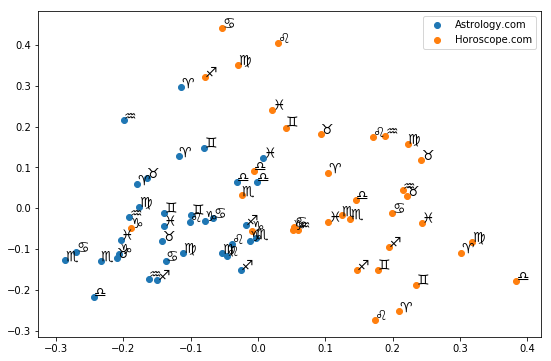

In [6]:
fig = plt.figure(figsize=(9, 6))

for source in df['Source'].unique():
    plt.scatter(horoscopes_t[df['Source'] == source, 0],
                horoscopes_t[df['Source'] == source, 1],
                label=source)

for i, point in enumerate(horoscopes_t):
    plt.annotate(signs_map[signs[i][0]], point, fontsize=14)

_ = plt.legend()

It appears that the zodiac signs are randomly distributed between the two sources and within each source. The only clear separator is between the sources, meaning that **there is structure in the words chosen by the different authors of the horoscope**, and only that distinction is visible in this projection.

However, this could be an artifact of the raw keywords subjected to TF-IDF. Perhaps the GloVe vector, which has some semantic structure, can shine a better light upon the data.

---

## Using GloVe

Now, let's map the words into a _bona fide_ vector model and see if we get a similar separation of points.

To do this we will first break the strings of horoscopes down into individual word tokens. These word tokens are not necessarily words in the conventional sense but rather any continuous string of non-whitespace character. This means we could have words like "---" or ".". GloVe also might not have these word tokens in the vector. An easy way out is to ignore the word tokens that do not exist and only consider the word tokens that do.

To make a vector of an entire sentence, we just add up the individual word token's vectors into a single 100-dimensional and take the average for each feature of the summed vector.

In [7]:
horoscopes_matrix_glove = []

for horoscope in horoscopes:
    xr = 0
    vector_sum = np.zeros(100,)
    for word in word_tokenize(horoscope[0].lower()):
        if glove.vocab.get(word) is not None:
            vector_sum = ((vector_sum * xr) + glove.get_vector(word)) / (xr + 1)
            xr += 1
    
    horoscopes_matrix_glove.append(vector_sum)

horoscopes_matrix_glove = np.array(horoscopes_matrix_glove)
horoscopes_glove_t = PCA(n_components=2).fit_transform(horoscopes_matrix_glove)

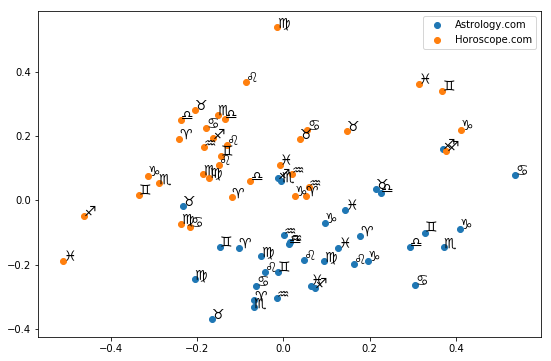

In [8]:
fig = plt.figure(figsize=(9, 6))

for source in np.unique(df['Source']):
    plt.scatter(horoscopes_glove_t[df['Source'] == source, 0],
                horoscopes_glove_t[df['Source'] == source, 1],
                label=source)

for i, point in enumerate(horoscopes_glove_t):
    plt.annotate(signs_map[signs[i][0]], point, fontsize=14)

_ = plt.legend()

Simliarly, the GloVe vectors show a clear separation between the sources but not within the source.

Another interesting analysis to look at is how the vectors move. Since the horoscopes are written daily, can there also be movement in a uniform direction for each horoscope? To see this we can plot arrows between the points from _yesterday_'s prediction to _today_ and to _tomorrow_.

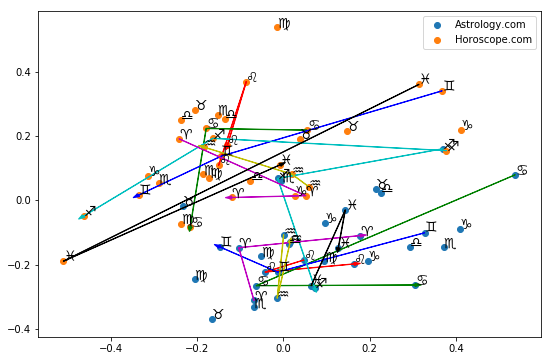

In [9]:
fig = plt.figure(figsize=(9, 6))

for source in np.unique(df['Source']):
    plt.scatter(horoscopes_glove_t[df['Source'] == source, 0],
                horoscopes_glove_t[df['Source'] == source, 1],
                label=source)

for i, point in enumerate(horoscopes_glove_t):
    plt.annotate(signs_map[signs[i][0]], point, fontsize=14)

cmap = {
    'leo': 'r',
    'cancer': 'g',
    'gemini': 'b',
    'sagittarius': 'c',
    'aries': 'm',
    'aquarius': 'y',
    'pisces': 'k',
}
    
for sign in cmap.keys():
    for source in df['Source'].unique():
        for now, later in [('yesterday', 'today'), ('today', 'tomorrow')]:
            id1 = df[(df['Sign'] == sign) &
                    (df['Source'] == source) &
                    (df['Day'] == now)].index[0]
            id2 = df[(df['Sign'] == sign) &
                    (df['Source'] == source) &
                    (df['Day'] == later)].index[0]
            p1, p2 = horoscopes_glove_t[id1], horoscopes_glove_t[id2]
            hw = 0.01 if later == 'tomorrow' else 0.
            plt.arrow(p1[0], p1[1], p2[0]-p1[0], p2[1]-p1[1],
                      head_width=hw, fc=cmap[sign], ec=cmap[sign])

_ = plt.legend()

While there are similarties in the directions of some zodiac signs within Astrology.com for Leo, Gemini and Cancer between yesterday and today, much of the rest are quite random. Perhaps with more days of data, we can truly say if the movements are totally random.

---

## More stuff

TODO...

In [10]:
from scipy.spatial.distance import pdist, squareform

Z_p = pdist(horoscopes_matrix_glove)
Z = squareform(Z_p)

In [11]:
c1, c2 = np.where(Z == Z_p.min())[0]
f1, f2 = np.where(Z == Z_p.max())[0]
print("Closest horoscope:", c1, c2)
print("Furthest horoscope:", f1, f2)

Closest horoscope: 8 28
Furthest horoscope: 2 56


Closest?

In [12]:
df['Horoscope'].iloc[8]

"Ready for yet another day of romance, sidelong glances and sweet stuff in general? Sure you are. It's your sign's job, and you'd better prepare yourself because this could well continue for quite some time -- especially if you've just been introduced to someone via a family member. See how important it is to keep an open mind? The last time they tried to fix you up, it turned out to be disastrous, but this time -- well, this time can obviously end up quite differently."

In [13]:
df['Horoscope'].iloc[28]

"Talking you into recreation, getting together with your playmates or just going out for the heck of it has never been an especially difficult task. That goes double today. You've been good -- well, relatively good -- for a long time now. Days, even. Maybe weeks. Anyway, it's time to treat yourself to something extra special. To celebrate how good you've been. See? It all makes perfect sense."

Furthest away?

In [14]:
df['Horoscope'].iloc[2]

"The way you're feeling now -- secretive, but with a burning need to tell someone what's on your mind and in your heart -- there's really only one thing to do. Get to your most trusted confidante and tell them you'll need at least an hour. You know that once they hear your voice you won't even have to ask them to listen."

In [15]:
df['Horoscope'].iloc[56]

"Communication, particularly with family members and romantic partners, could take place more subtly than verbally today. Nonetheless, Pisces, you'll sense strong love and support from e one. Romance, especially, should be intense and sensual, so this is a great day to schedule an evening alone with a lover. Inspiration for creative projects, particularly in the home, could well up from deep inside. Don't suppress it - let it flow."